# Coursework 2: Internet of Things.

This document contains Section 2 of Coursework 2, *Data analytics, inferences and insights*  
  
The analytics performed in this document are on historical data. This project also included some real-time analysis and calculations [Power, Cost, Predicted Cost], these are described in more detail in the report.  

## Time-Series Data Sources 
  
The 2 time-series data sources used for this project are a Bosch BME680 sensor, configured for a Raspberry Pi, and API Data from the Open Weather Map.  
  
Each section below explains these data-sources, the associated sampling rates and why they were selected.  
  
**Assumptions:**  
* Heat dissipation is constant for all temperatures.
* House is built to building standard for -2&deg;C.  
* API Weather Data is accurate to 2 decimal places.

## BME680

### Temperature  
  
Write here. Include the .gov reference of 30 Secs to start a fire and OWM information regarding 10 minute sampling rate.  
  
  
### Humidity      
  
Write here.  
  
  
### Pressure  
  
Write here.  
  
  
## Open Weather Map (OWM API)

### Temperature  
  
Write here. Include the .gov reference of 30 Secs to start a fire and OWM information regarding 10 minute sampling rate.  
  
  
### Humidity      
  
Write here.  
  
  
### Pressure  
  
Write here.  
  
  
## Generated Data
  
These are streams of data which are generated onboard the Raspberry Pi, as the d
### Power  
  
Write here. Use the heat dissapation estimation here.  
  
  
### Cost  
  
Write here. Use the british gas.  
  
  

## Import Modules

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)
from datetime import datetime, timedelta
import time
from sklearn.preprocessing import normalize
from scipy.interpolate import interp1d
import seaborn as sns
from bokeh.charts import Histogram

## Packages for analyzing time series
import statsmodels.api as sm
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

C:\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



## Read data from CSV file

In [2]:
data = pd.read_csv(
    './data-storage/usb/data_log_combined.csv')

n, m = np.shape(data)

data.head()

time  temp_in  press_in  hum_in        time_measured  \
0  2019/01/03 02:25:08    18.92   1043.99  55.893  2019/01/03 01:50:00   
1  2019/01/03 02:25:25    18.92   1043.99  55.990  2019/01/03 01:50:00   
2  2019/01/03 02:25:41    18.92   1043.99  56.198  2019/01/03 01:50:00   
3  2019/01/03 02:26:01    18.91   1044.00  55.882  2019/01/03 01:50:00   
4  2019/01/03 02:26:17    18.91   1044.00  56.124  2019/01/03 01:50:00   

   temp_out  press_out  hum_out time_diff  temp_diff  press_diff  hum_diff  \
0      3.67       1043       75   0:35:08      15.25        0.99   -19.107   
1      3.67       1043       75   0:35:25      15.25        0.99   -19.010   
2      3.67       1043       75   0:35:41      15.25        0.99   -18.802   
3      3.67       1043       75   0:36:01      15.24        1.00   -19.118   
4      3.67       1043       75   0:36:17      15.24        1.00   -18.876   

     power  cost_window  cost_predict  
0  1936.75        0.000          0.00  
1  1936.75        0.023          5.38  
2  1936.75        0.030          5.38  
3  1935.48        0.024          5.38  
4  1935.48        0.023          5.38

In [3]:
time = data.iloc[:,0]
print(type(time[0]))
for i in range(n):
    t = datetime.strptime(time[i], '%Y/%m/%d %H:%M:%S')
    time[i] = t

time.head()

<type 'str'>


0    2019-01-03 02:25:08
1    2019-01-03 02:25:25
2    2019-01-03 02:25:41
3    2019-01-03 02:26:01
4    2019-01-03 02:26:17
Name: time, dtype: object

In [4]:
inside = data.iloc[:,1:4]

inside.head()

temp_in  press_in  hum_in
0    18.92   1043.99  55.893
1    18.92   1043.99  55.990
2    18.92   1043.99  56.198
3    18.91   1044.00  55.882
4    18.91   1044.00  56.124

In [5]:
outside = data.iloc[:,5:8]

outside.head()

temp_out  press_out  hum_out
0      3.67       1043       75
1      3.67       1043       75
2      3.67       1043       75
3      3.67       1043       75
4      3.67       1043       75

In [6]:
delta = data.iloc[:,9:12]

delta.head()

temp_diff  press_diff  hum_diff
0      15.25        0.99   -19.107
1      15.25        0.99   -19.010
2      15.25        0.99   -18.802
3      15.24        1.00   -19.118
4      15.24        1.00   -18.876

In [7]:
delta_temp = data.iloc[:,9]
metrics = data.iloc[:,12:]

frames = [delta_temp, metrics]

metrics = pd.concat(frames, axis=1)

metrics.head()

temp_diff    power  cost_window  cost_predict
0      15.25  1936.75        0.000          0.00
1      15.25  1936.75        0.023          5.38
2      15.25  1936.75        0.030          5.38
3      15.24  1935.48        0.024          5.38
4      15.24  1935.48        0.023          5.38

In [8]:
temperature_inside = inside['temp_in']
pressure_inside = inside['press_in']
humidity_inside = inside['hum_in']


temperature_outside = outside['temp_out']
pressure_outside = outside['press_out']
humidity_outside = outside['hum_out']

delta_temperature = delta['temp_diff']
delta_pressure = delta['press_diff']
delta_humidity = delta['hum_diff']

power = metrics['power']
cost_increment = metrics['cost_window']
cost_hourly = metrics['cost_predict']

## Time-Series Plot

This section contains simple time-series plots. They show each data stream, over the recording period.  
As a result, they also highlight the blackspots in the data recording. This was as a result of the exception for the API request code check failing. Various fixes were attempted, and failed, the final fix was commited on the night of 6th-7th January as shown by the continous data after this point. With this fix, the program is robust enough to run until all memory is utilised. As the data is backed-up on Github, a future fix would be to erase the data after a specified period, perhaps once a month.

### Temperature, Humidity, Pressure

**Inside:** BME680  
  
**Outside:** Open Weather Map API

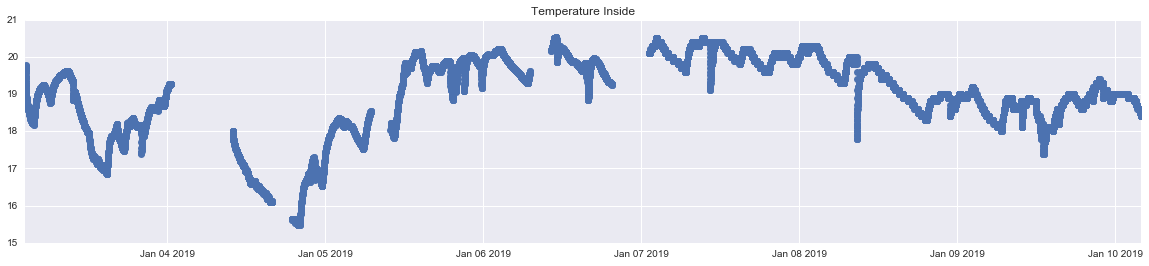

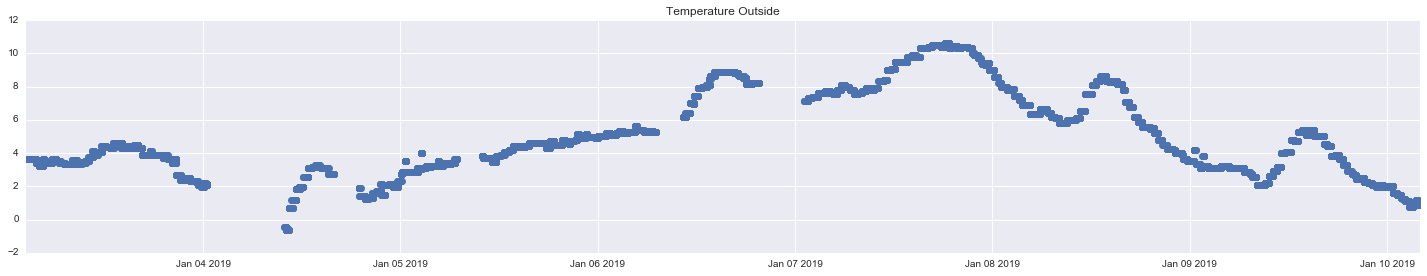

In [9]:
plt.figure(1, figsize = (20,4))
plt.plot_date(time, temperature_inside)
plt.title('Temperature Inside')

plt.figure(2, figsize = (20,4))
plt.plot_date(time, temperature_outside)
plt.title('Temperature Outside')

plt.tight_layout()

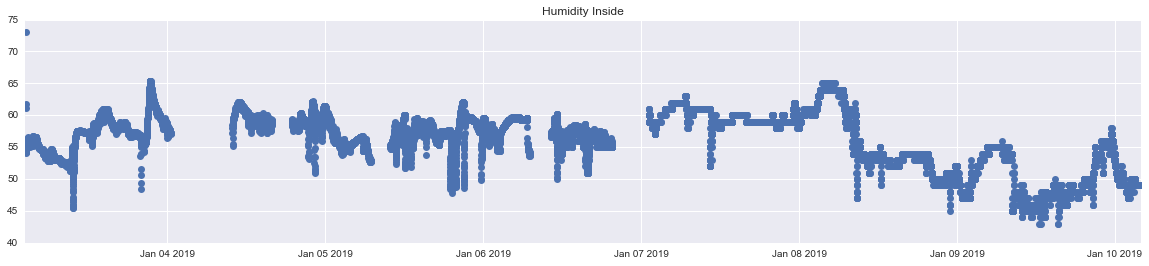

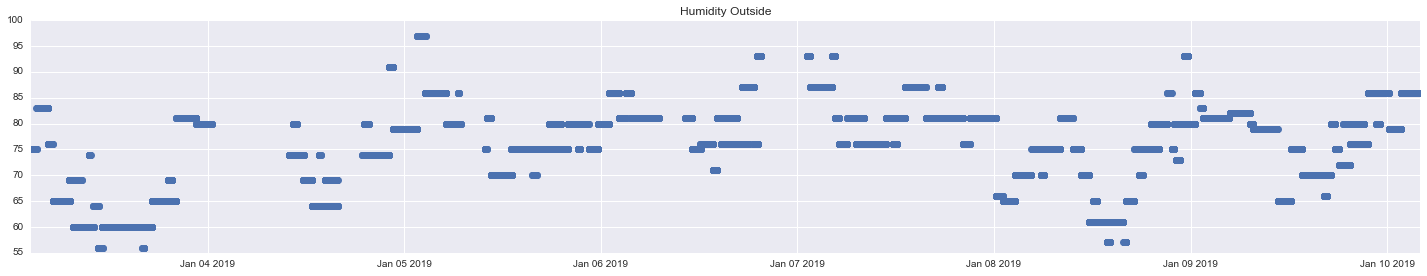

In [10]:
plt.figure(1, figsize = (20,4))
plt.plot_date(time, humidity_inside)
plt.title('Humidity Inside')

plt.figure(2, figsize = (20,4))
plt.plot_date(time, humidity_outside)
plt.title('Humidity Outside')

plt.tight_layout()

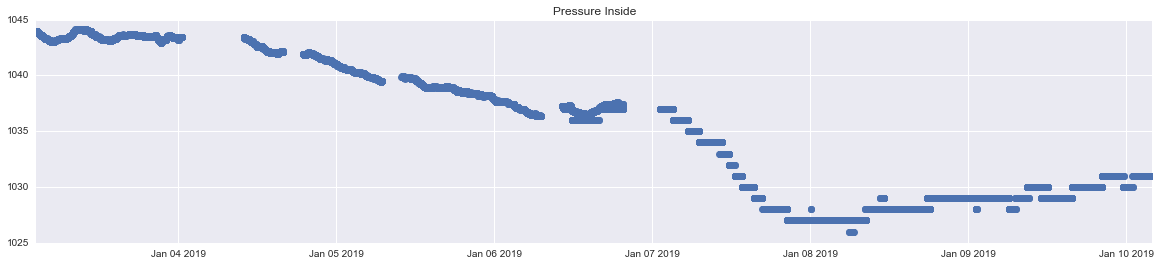

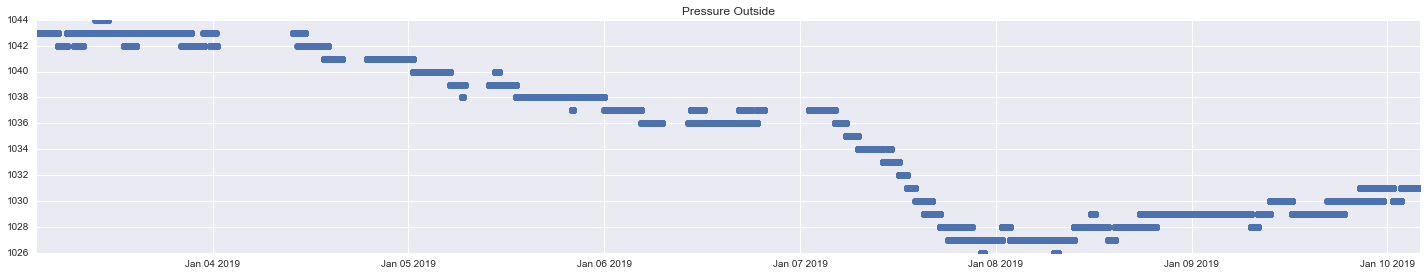

In [11]:
plt.figure(1, figsize = (20,4))
plt.plot_date(time, pressure_inside)
plt.title('Pressure Inside')

plt.figure(2, figsize = (20,4))
plt.plot_date(time, pressure_outside)
plt.title('Pressure Outside')

plt.tight_layout()

### Metrics

These metrics were computed as the data was recorded. The intention for this is to make it easier for apps, using this device, to read the metrics from the house. Additionally, if there were multiple devices in each house, it would be easier for each device to compute the metrics for their house due to varying energy suppliers and household heat dissipation.

**Power(W): P** Calculated using the temperature difference and a heat dissipation constant, as derived [here](https://www.open.edu/openlearn/nature-environment/the-environment/energy-buildings/content-section-2.4.1). The constant in this example was originally trialled, and resulted in similar cost predictions to the smart meter in the house the recording was coming from. However, this was during the holiday period and when the rest of the occupants - with the largest and most inefficiently heated rooms - returned this was no longer an accurate prediction. However, the constant was not changed as this would skew the recordings. Therefore, the constant was compared after recording had completed, of which the findings are in the main report.

**Cost(£):** There are two aspects to the cost metric, cost increment and cost prediction.  
  
The **cost increment** is based on the time since the last recording, and then using P<sub>t</sub> and P<sub>t-1</sub> estimates to calculate the energy expended during this period. Then, using the [British Gas cost per kWh of Gas](https://www.ukpower.co.uk/home_energy/tariffs-per-unit-kwh), as they are our supplier, to calculate the cost of the energy over that window.  
  
The **cost prediction** is based solely on the instantaneous Power estimate, this is then divided by 1000 and multiplied by the cost per kWh. This is useful in showing a user how much their energy should cost for that day, allowing them to make decisions based on this. This can then be extrapolated to daily and weekly predictions as a more relevant statistic to which users can make decisions. These metrics are used in the API, to make it simpler for apps using the data to show important information.

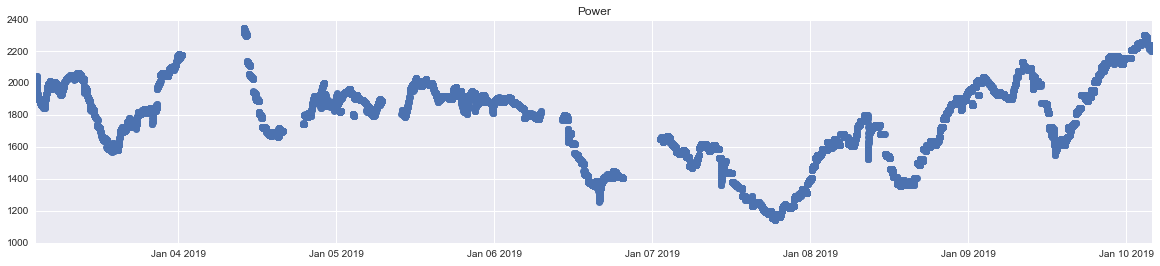

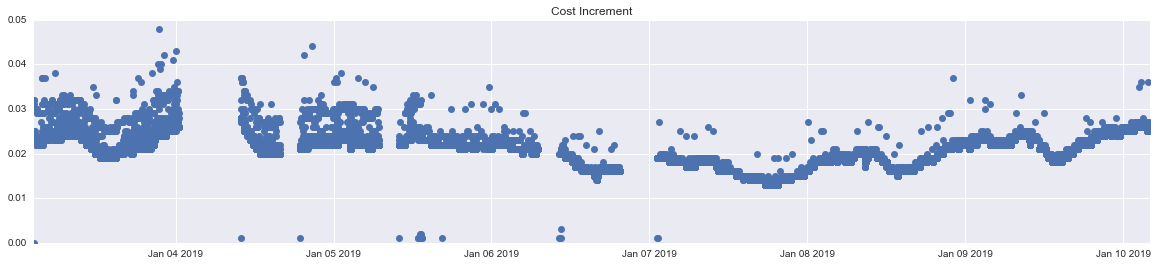

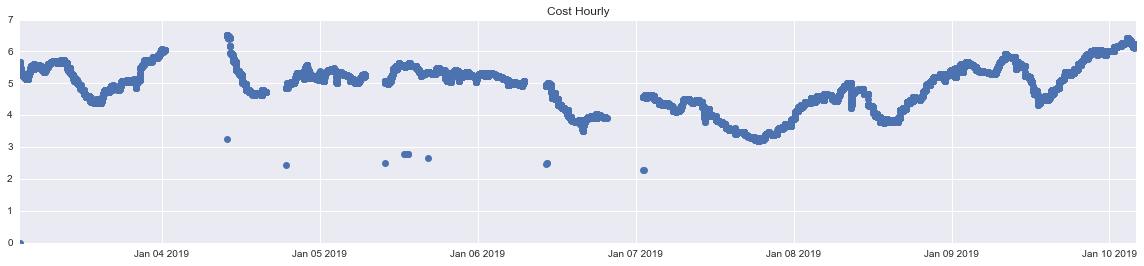

In [12]:
plt.figure(1, figsize = (20,4))
plt.plot_date(time, power)
plt.title('Power')

plt.figure(2, figsize = (20,4))
plt.plot_date(time, cost_increment)
plt.title('Cost Increment')

plt.figure(3, figsize = (20,4))
plt.plot_date(time, cost_hourly)
plt.title('Cost Hourly')

# Post-processing

Tidying the data up.

In [13]:
data_interp = pd.read_csv(
    './data-storage/usb/data_log_combined.csv')

n, m = data_interp.shape

data_interp.head()

time  temp_in  press_in  hum_in        time_measured  \
0  2019/01/03 02:25:08    18.92   1043.99  55.893  2019/01/03 01:50:00   
1  2019/01/03 02:25:25    18.92   1043.99  55.990  2019/01/03 01:50:00   
2  2019/01/03 02:25:41    18.92   1043.99  56.198  2019/01/03 01:50:00   
3  2019/01/03 02:26:01    18.91   1044.00  55.882  2019/01/03 01:50:00   
4  2019/01/03 02:26:17    18.91   1044.00  56.124  2019/01/03 01:50:00   

   temp_out  press_out  hum_out time_diff  temp_diff  press_diff  hum_diff  \
0      3.67       1043       75   0:35:08      15.25        0.99   -19.107   
1      3.67       1043       75   0:35:25      15.25        0.99   -19.010   
2      3.67       1043       75   0:35:41      15.25        0.99   -18.802   
3      3.67       1043       75   0:36:01      15.24        1.00   -19.118   
4      3.67       1043       75   0:36:17      15.24        1.00   -18.876   

     power  cost_window  cost_predict  
0  1936.75        0.000          0.00  
1  1936.75        0.023          5.38  
2  1936.75        0.030          5.38  
3  1935.48        0.024          5.38  
4  1935.48        0.023          5.38

## Setting the Index

This section of the code converts the time strings back into datetime objects and sets them as the index. This allows for analysis of the gap between samples, and consequent interpolation of the data in these gaps. This approach makes it simpler to add new timestamps, as they can be generated, placed in a dataframe, appended to the original and then sorted.

In [14]:
for i in range(n):
    t = datetime.strptime(data_interp['time'][i], '%Y/%m/%d %H:%M:%S')
    data_interp['time'][i] = t
    
data_interp = data_interp.set_index('time')

C:\Anaconda2\lib\site-packages\seaborn\categorical.py:454: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



"\nUnforunately, the built-in histogram functions don't support discrete bins and timedelta as easily as plotly.\nTherefore, a boxplot has been used to show the distribution of gaps between samples.\n"

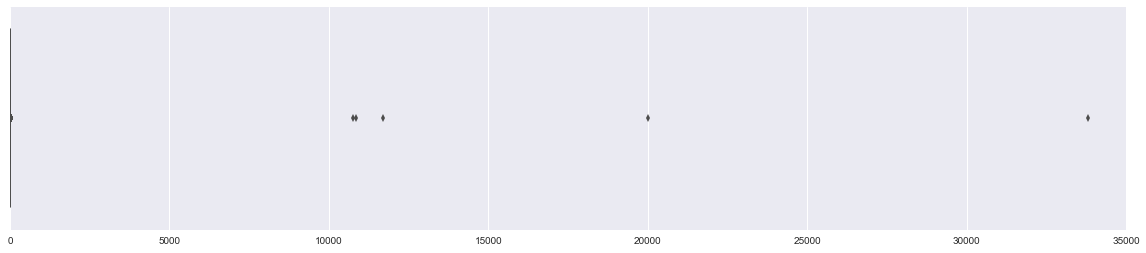

In [15]:
times = data_interp.index.tolist()
sample_periods = sorted(np.diff(times)) #times are recorded before pseudo-samples added.

sample_periods_sec = []
x = 0
for i in range(len(sample_periods)):
    if sample_periods[i].total_seconds() > 0:
        sample_periods_sec.append(sample_periods[i].total_seconds())
    else: 
        pass


plt.figure(1, figsize = (20,4))
sns.boxplot(x = sample_periods_sec)

'''
Unforunately, the built-in histogram functions don't support discrete bins and timedelta as easily as plotly.
Therefore, a boxplot has been used to show the distribution of gaps between samples.
'''

# plt.figure(2)
# sns.distplot(sample_periods_sec)
# p = Histogram(sample_periods_sec)
# output_notebook()  ## output inline

# show(p)

## Removing the noise

The Histogram above shows the wide spread of sampling windows which were used. In the following section, these large gaps will be amended and data will be interpolated between the existing data. However, to ensure the interpolation is accurate, the noise shown in the cost graphs will need to be removed. This noise is present because some of the sample windows are much smaller or larger than 15s. Therefore, the cost increment, which is calculated directly from the window, also varies greatly about the mean.  
  
### Boxplots

The boxplots below show the outliers for both the Cost Increment and the Cost Prediction.  
  
The **Cost Increment** plot shows lots of outliers, due to this variance in sampling.  
  
The **Cost Prediction** plot shows fewer outliers, all of which seem to be situated at 0. This is due to the calculation for power, which originally returned 0 for the first recording. This was later amended and returned half of the predicted power, resulting in a less significant impact on the overall dataset.
  
The following section will address these outliers and then go on to interpolate the currently incomplete dataset.

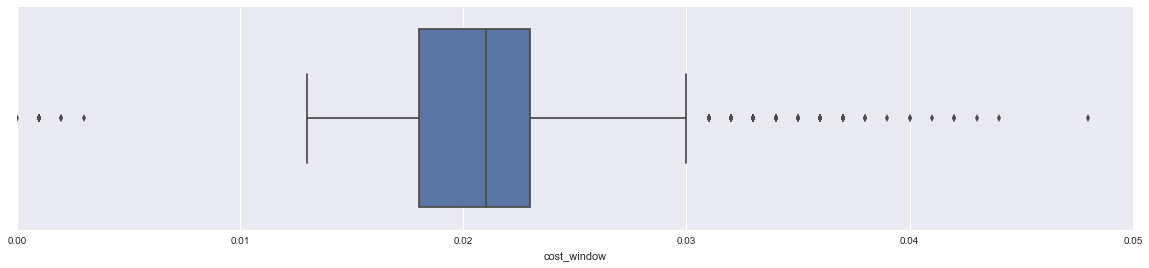

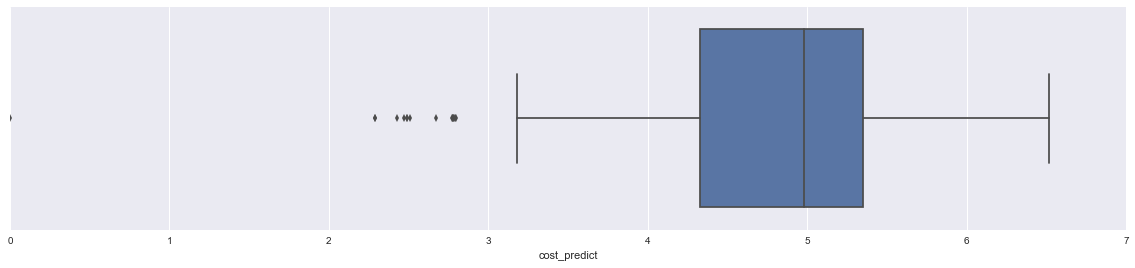

In [16]:
plt.figure(1, figsize = (20,4))
sns.boxplot(x = data_interp['cost_window'])
plt.figure(2, figsize = (20,4))
sns.boxplot(x = data_interp['cost_predict'])

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          7.00000000e+00,   2.23000000e+02,   4.62600000e+03,
          8.04200000e+03,   9.48000000e+03,   1.16410000e+04,
          2.23500000e+03]),
 array([ 0.   ,  0.652,  1.304,  1.956,  2.608,  3.26 ,  3.912,  4.564,
         5.216,  5.868,  6.52 ]),
 <a list of 10 Patch objects>)

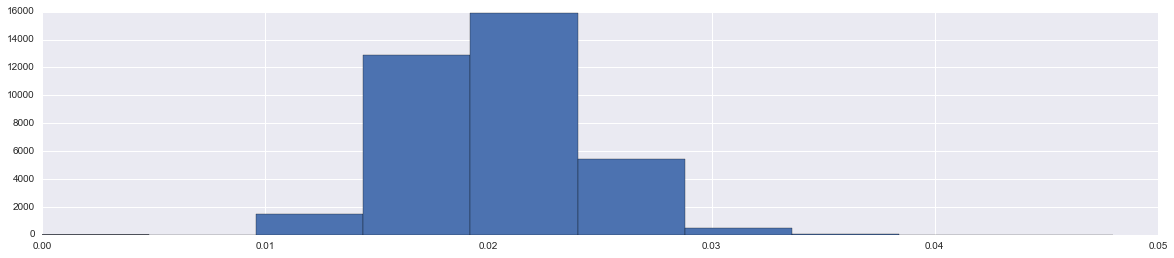

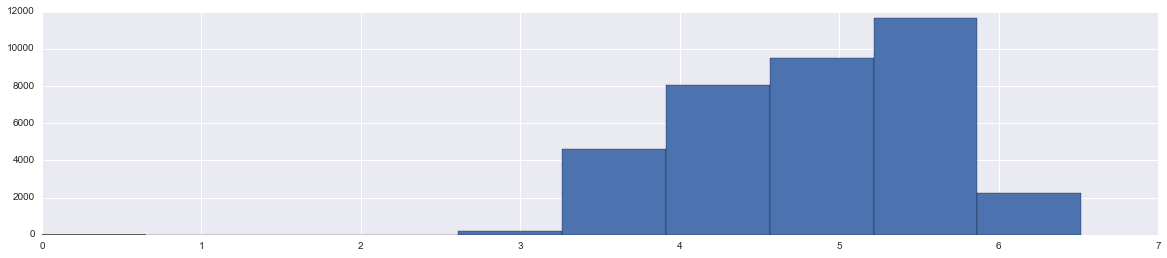

In [17]:
plt.figure(1, figsize = (20,4))
plt.hist(x = data_interp['cost_window'])
plt.figure(2, figsize = (20,4))
plt.hist(x = data_interp['cost_predict'])

In [18]:
lq = data_interp['cost_window'].quantile(.25)
uq = data_interp['cost_window'].quantile(.75)
iqr = uq-lq

lb = lq-1.5*iqr
ub = uq+1.5*iqr

data_interp = data_interp.drop(data_interp[data_interp['cost_window'] < lb].index)
data_interp = data_interp.drop(data_interp[data_interp['cost_window'] > ub].index)

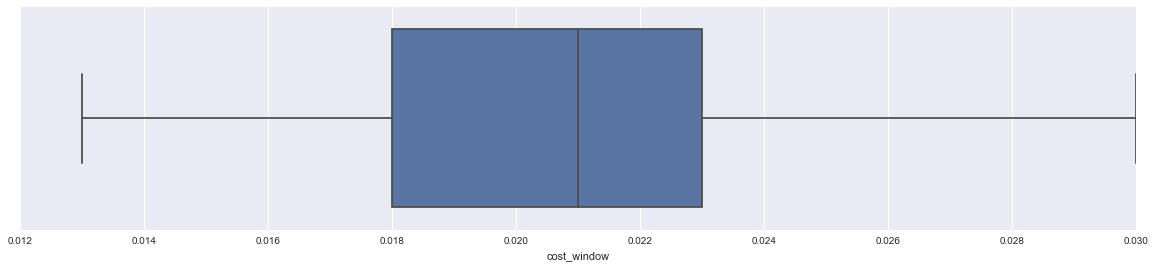

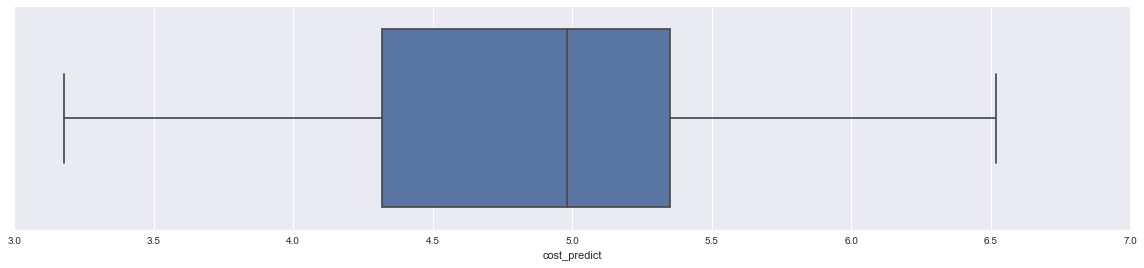

In [19]:
plt.figure(1, figsize = (20,4))
sns.boxplot(x = data_interp['cost_window'])
plt.figure(2, figsize = (20,4))
sns.boxplot(x = data_interp['cost_predict'])

(array([ 1532.,  2578.,  3633.,  4447.,  4551.,  4813.,  8273.,  3896.,
         1625.,   608.]),
 array([ 3.18 ,  3.514,  3.848,  4.182,  4.516,  4.85 ,  5.184,  5.518,
         5.852,  6.186,  6.52 ]),
 <a list of 10 Patch objects>)

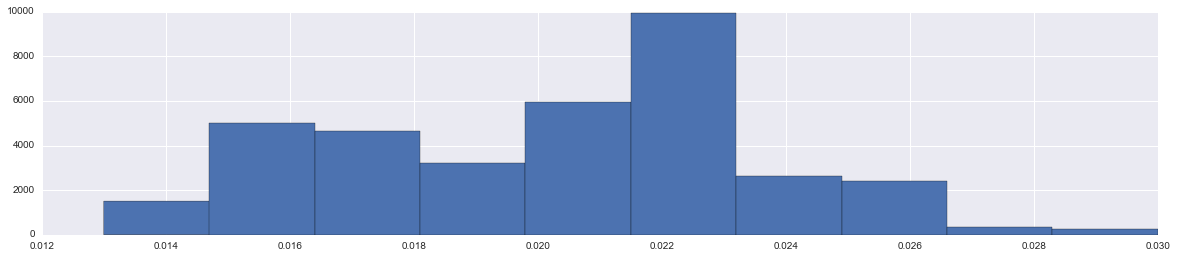

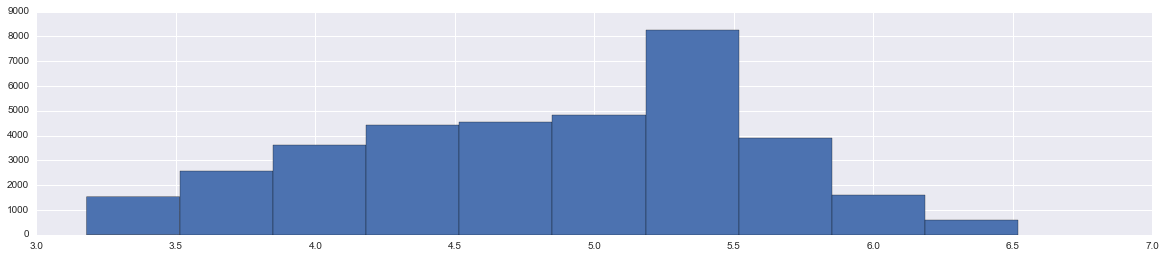

In [20]:
plt.figure(1, figsize = (20,4))
plt.hist(x = data_interp['cost_window'])
plt.figure(2, figsize = (20,4))
plt.hist(x = data_interp['cost_predict'])

In [21]:
index_list = []
for i in range(n):
    if i == 0:
        pass
    else:
        if (times[i] - times[i-1]).total_seconds() >= 24: #Set 60 seconds as maximum sample window.
            index_list.append((times[i-1],times[i]))
        else: continue

In [22]:
x = 0
total = timedelta(0)
for datetimes in index_list:
    x += 1
    print('Gap in Data {}:'.format(x))
    print('Start time: {}'.format(datetimes[0]))
    print('End time: {}'.format(datetimes[1]))
    duration = datetimes[1] - datetimes[0]
    print('Duration: {}'.format(duration))
    print('------------')
    total += duration

Gap in Data 1:
Start time: 2019-01-03 03:45:07
End time: 2019-01-03 03:45:33
Duration: 0 days 00:00:26
------------
Gap in Data 2:
Start time: 2019-01-03 03:46:21
End time: 2019-01-03 03:46:47
Duration: 0 days 00:00:26
------------
Gap in Data 3:
Start time: 2019-01-03 04:10:04
End time: 2019-01-03 04:10:28
Duration: 0 days 00:00:24
------------
Gap in Data 4:
Start time: 2019-01-03 05:44:59
End time: 2019-01-03 05:45:24
Duration: 0 days 00:00:25
------------
Gap in Data 5:
Start time: 2019-01-03 11:29:22
End time: 2019-01-03 11:29:47
Duration: 0 days 00:00:25
------------
Gap in Data 6:
Start time: 2019-01-03 11:58:49
End time: 2019-01-03 11:59:15
Duration: 0 days 00:00:26
------------
Gap in Data 7:
Start time: 2019-01-03 14:58:46
End time: 2019-01-03 14:59:12
Duration: 0 days 00:00:26
------------
Gap in Data 8:
Start time: 2019-01-03 15:00:40
End time: 2019-01-03 15:01:06
Duration: 0 days 00:00:26
------------
Gap in Data 9:
Start time: 2019-01-03 17:30:07
End time: 2019-01-03 17:3

In [23]:
total_seconds = total.total_seconds()
total_hours = int(total_seconds/3600)
remaining_seconds = total_seconds%3600
total_minutes = int(remaining_seconds/60)
total_seconds = int(remaining_seconds%60)

print(
    'Total duration of recording to be interpolated: {} hours {} minutes {} seconds'.format(
        total_hours, total_minutes, total_seconds)
)

Total duration of recording to be interpolated: 24 hours 27 minutes 27 seconds


In [24]:
new_indexes = []

for i in range(len(index_list)):
    date_x = index_list[i][0]
    date_b = index_list[i][1]
    temp_list = []
    while date_x < date_b:
        date_x += timedelta(seconds=15)
        temp_list.append(date_x)
    new_indexes = new_indexes + temp_list
    
new_samples = len(new_indexes)
print('There are {} samples to be interpolated'.format(new_samples))

There are 5883 samples to be interpolated


In [25]:
new_samples_df = pd.DataFrame(index=new_indexes, columns=list(data_interp))
data_interp = data_interp.append(new_samples_df)
data_interp = data_interp.sort_index()

n1, m2 = data_interp.shape

if n1 > n:
    print('DataFrame Enlarged')
else:
    print('Enlarging Dataframe Failed')

'''
The code beneath is no longer true after the addition of the noise reducing section above.
'''
# if n1 - n == new_samples:
#     print('The new dataframe has been successfully constructed.')
# else:
#     print('Dataframe construction failed.')

DataFrame Enlarged


'\nThe code beneath is no longer true after the addition of the noise reducing section above.\n'

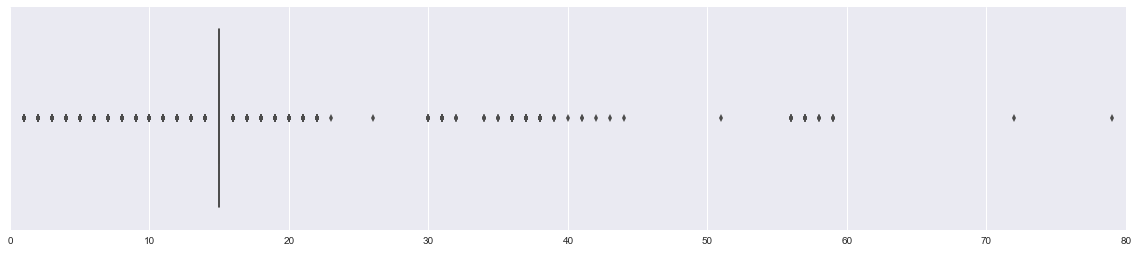

In [26]:
times = data_interp.index.tolist()
sample_periods = sorted(np.diff(times)) #times are recorded before pseudo-samples added.

sample_periods_sec = []
x = 0
for i in range(len(sample_periods)):
    if sample_periods[i].total_seconds() > 0:
        sample_periods_sec.append(sample_periods[i].total_seconds())
    else: 
        pass


plt.figure(1, figsize = (20,4))
sns.boxplot(x = sample_periods_sec)

## Interpolation

The data was inputted using a linear approximation. This was because it could be implemented with a single line of code. A cubic interpolation would have generated a better approximation, however this wasn't used due to the simplicity of implementing a linear interpolation with a pandas dataframe.

In [27]:
data_interp = data_interp.interpolate(method='linear')

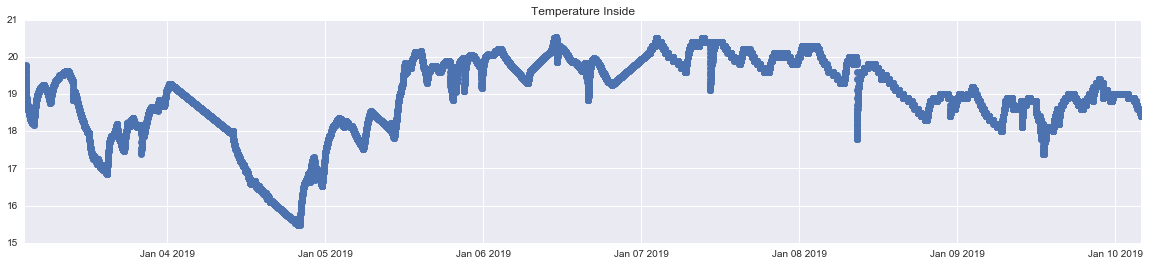

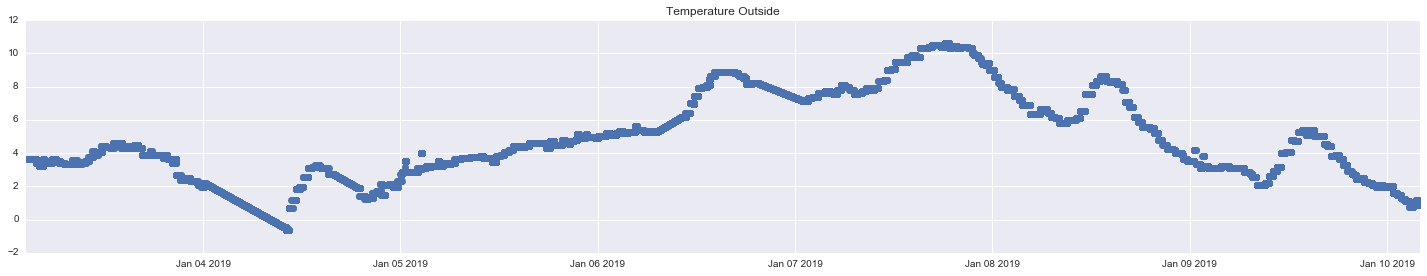

In [28]:
plt.figure(1, figsize = (20,4))
plt.plot_date(data_interp.index,data_interp['temp_in'])
plt.title('Temperature Inside')

plt.figure(2, figsize = (20,4))
plt.plot_date(data_interp.index,data_interp['temp_out'])
plt.title('Temperature Outside')

plt.tight_layout()

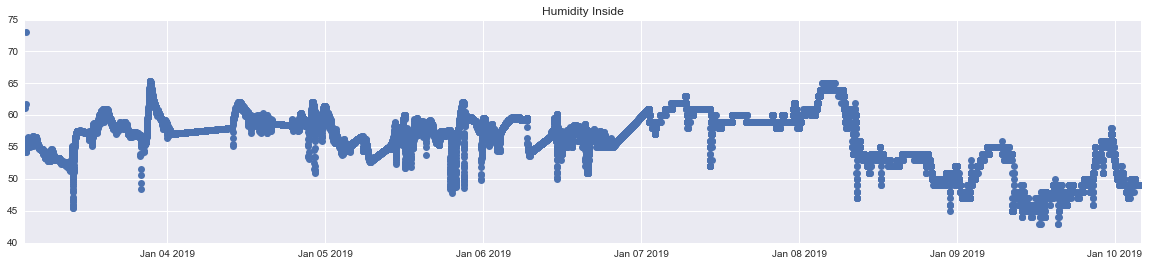

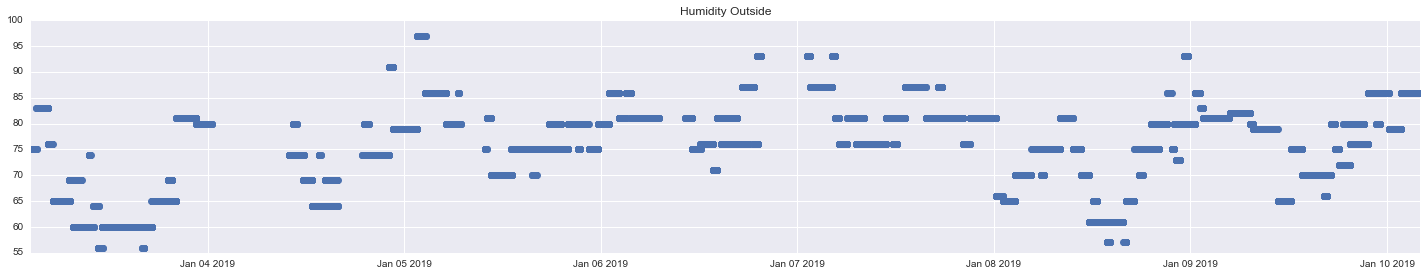

In [29]:
plt.figure(1, figsize = (20,4))
plt.plot_date(data_interp.index, data_interp['hum_in'])
plt.title('Humidity Inside')

plt.figure(2, figsize = (20,4))
plt.plot_date(data_interp.index, data_interp['hum_out'])
plt.title('Humidity Outside')

plt.tight_layout()

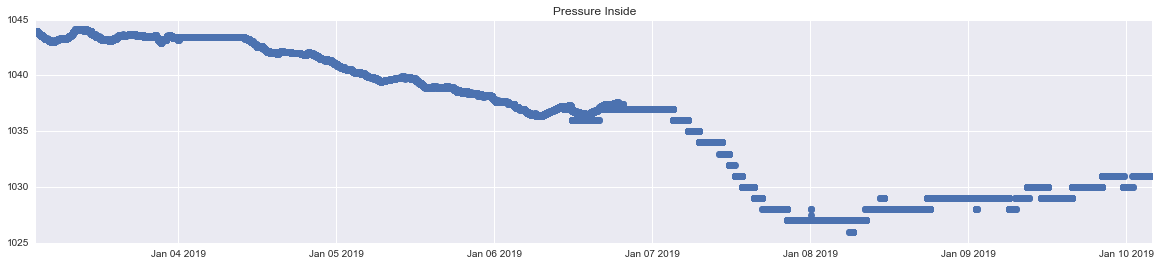

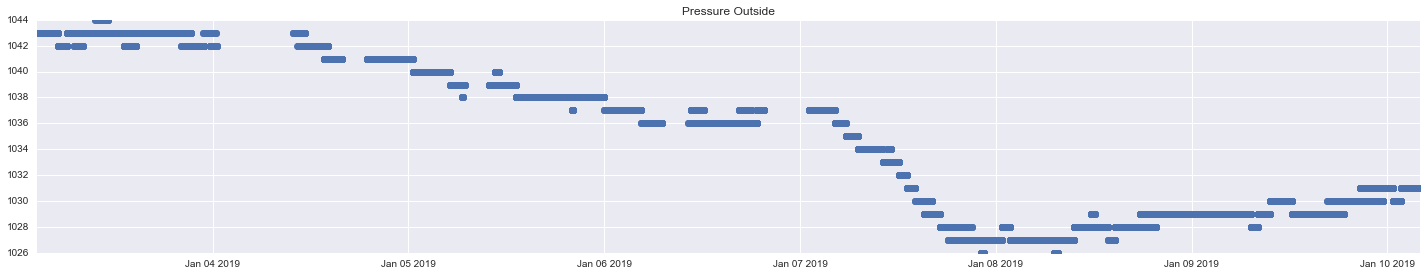

In [30]:
plt.figure(1, figsize = (20,4))
plt.plot_date(data_interp.index, data_interp['press_in'])
plt.title('Pressure Inside')

plt.figure(2, figsize = (20,4))
plt.plot_date(data_interp.index, data_interp['press_out'])
plt.title('Pressure Outside')

plt.tight_layout()

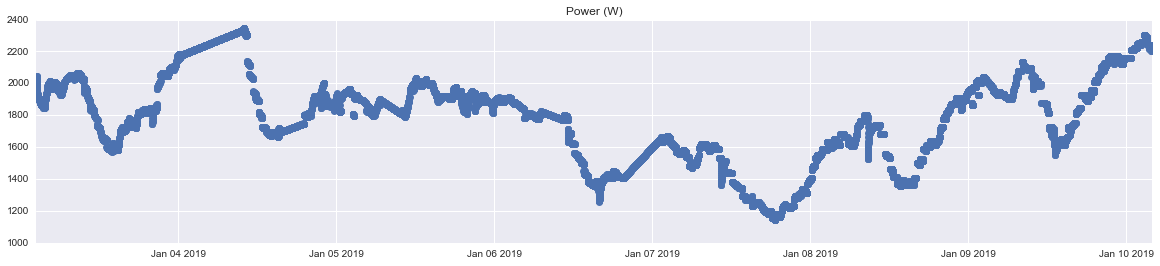

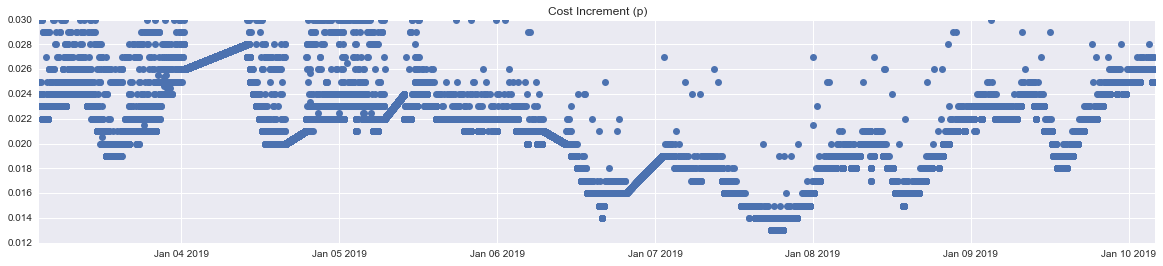

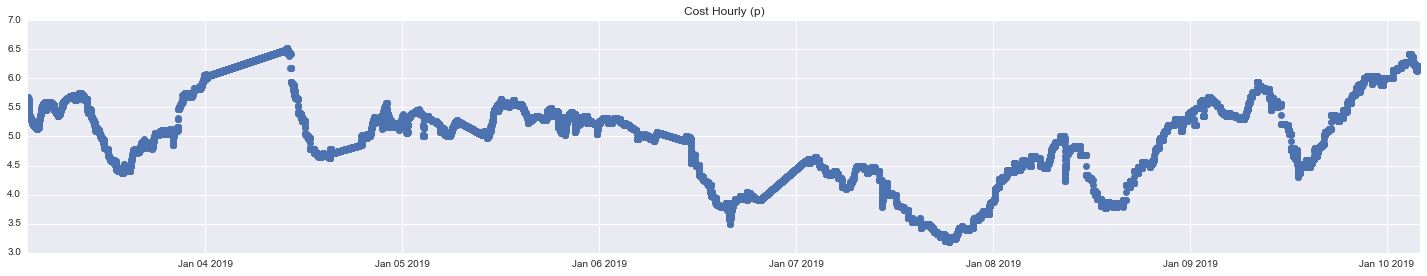

In [31]:
plt.figure(1, figsize = (20,4))
plt.plot_date(data_interp.index, data_interp['power'])
plt.title('Power (W)')

plt.figure(2, figsize = (20,4))
plt.plot_date(data_interp.index, data_interp['cost_window'])
plt.title('Cost Increment (p)')

plt.figure(3, figsize = (20,4))
plt.plot_date(data_interp.index, data_interp['cost_predict'])
plt.title('Cost Hourly (p)')

plt.tight_layout()

## Analytics, Inferences & Insights

Having cleaned and post-processed the data, the following section analyses the data to gain interesting inferences and insights, in addition to those which have already been made throughout the notebook.

### Downsampling

The data was sampled once every 15 seconds. This was to ensure that a fire could be detected if one were too occur, allowing for an occupant to be notified of the danger. However, this sampling rate isn't required for post-recording analysis, therefore the dataset can be downsampled to allow for faster processing and analysis of the data.

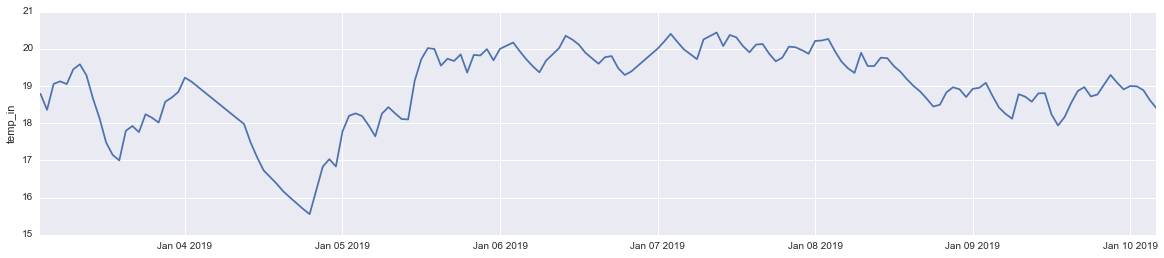

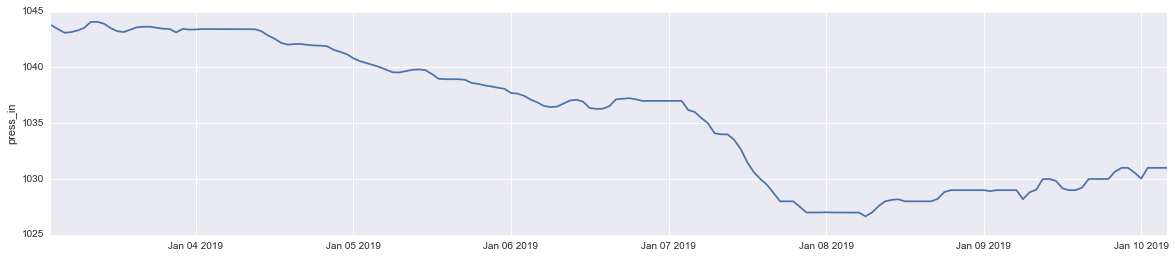

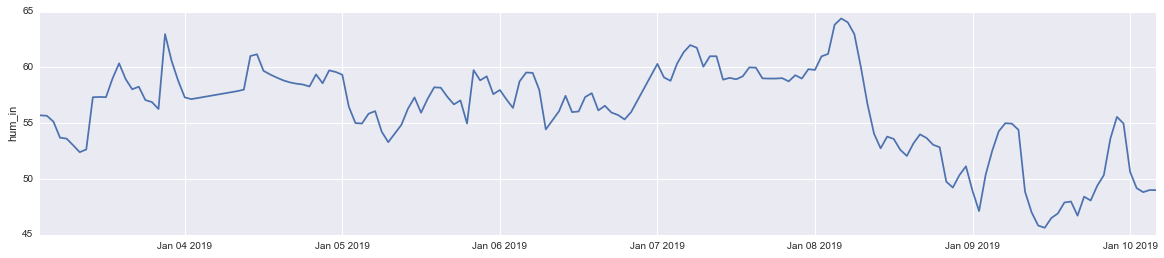

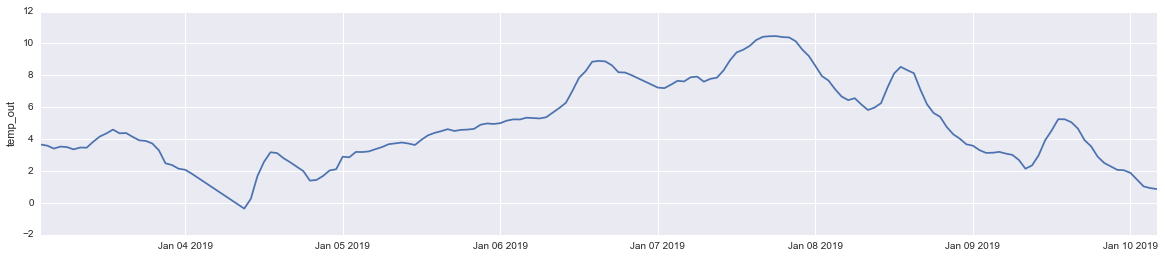

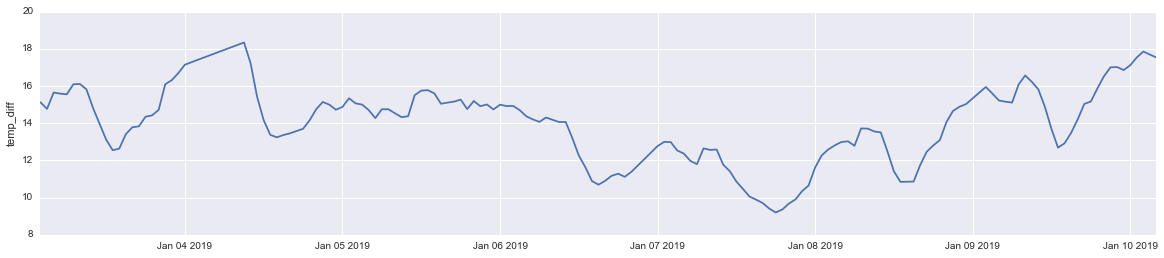

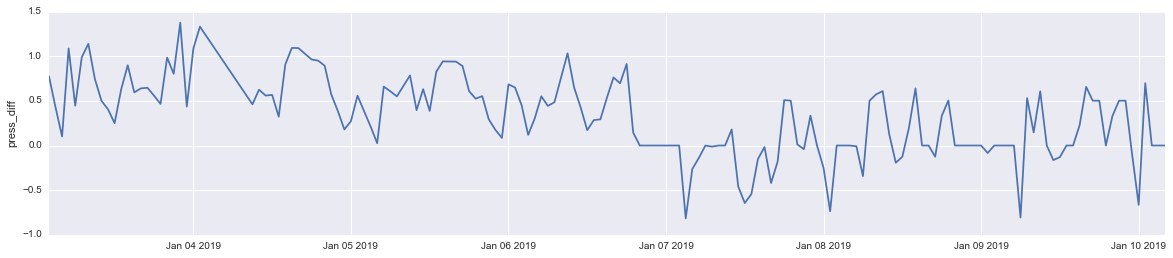

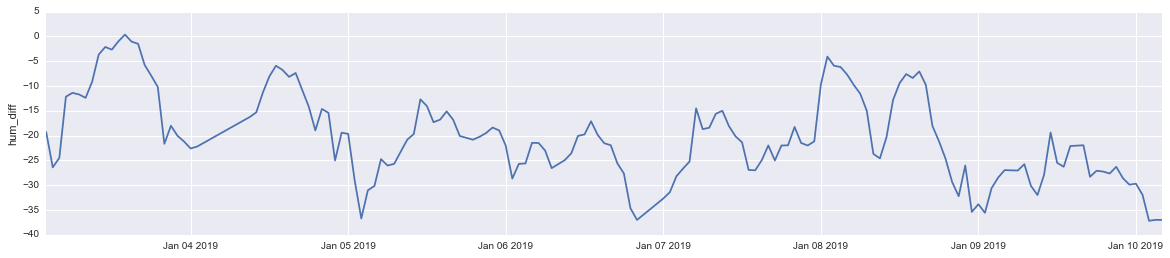

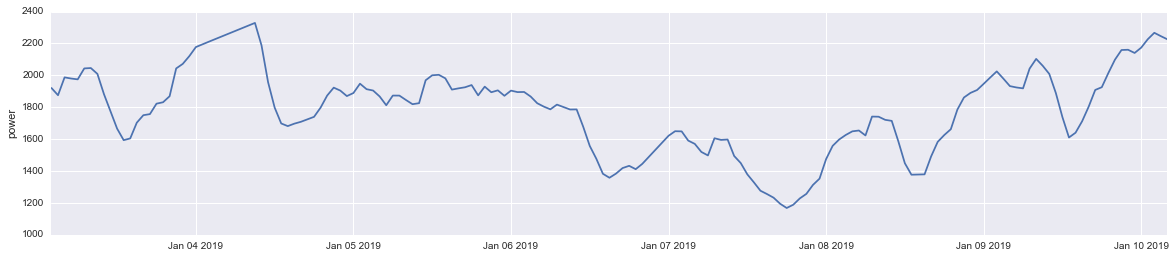

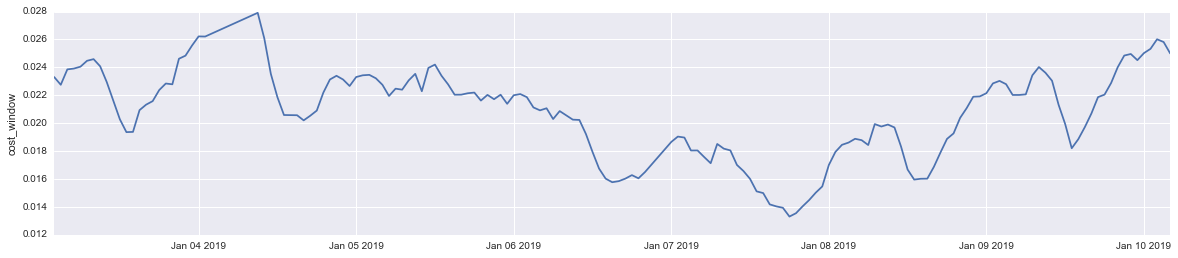

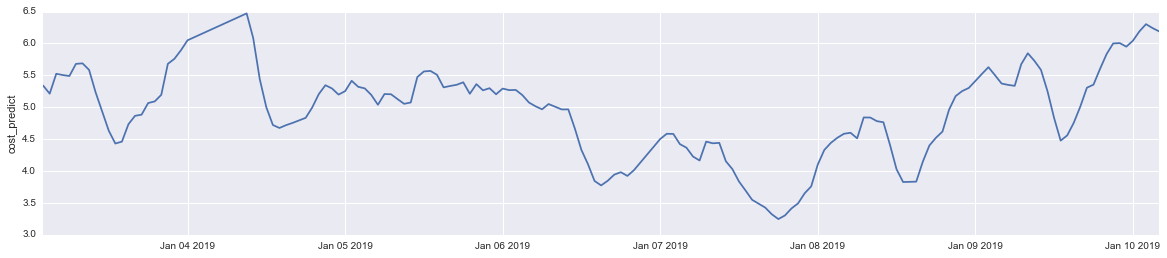

In [54]:
ts = data_interp[:]
ts = ts.resample('1h').mean()
for i in range(len(list(ts))):
    lst = list(ts)
    plt.figure(i, figsize = (20,4))
    plt.plot(ts.index, ts[lst[i]])
    plt.ylabel(lst[i])

### Normalised Temperature Data

The plots below show the normalised temperature data over time. As expected, the indoor temperature stays relatively constant with the outdoor temperature varying depending on weather conditions.

In [55]:
normalised=(ts-ts.min())/(ts.max()-ts.min())

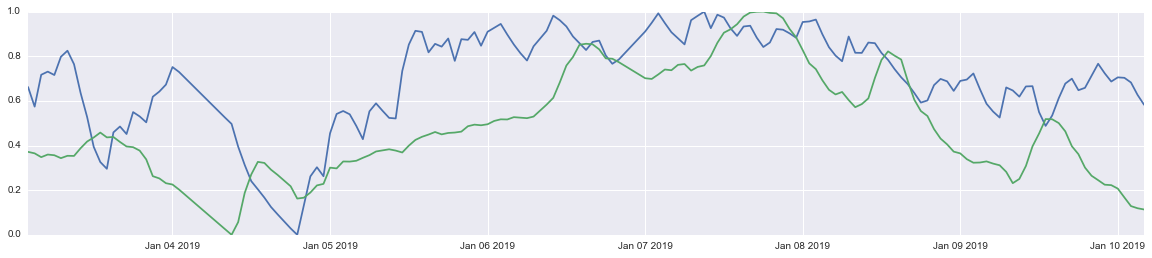

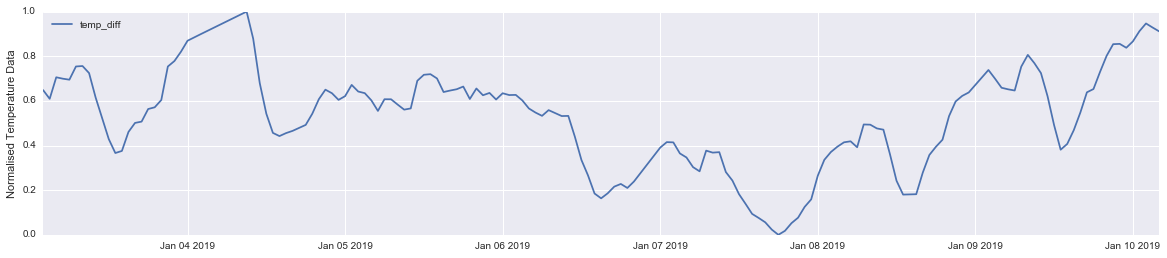

In [34]:
plt.figure(1, figsize = (20,4))
plt.plot(normalised.index, normalised['temp_in'])
plt.plot(normalised.index, normalised['temp_out'])

plt.figure(2, figsize = (20,4))
plt.plot(normalised.index, normalised['temp_diff'])
plt.legend(loc = 'best')
plt.ylabel('Normalised Temperature Data')

hum_out and press_out seem to be dropped during the downsampling. This is most likely because they are integers as opposed to floats. However, I haven't managed to identify the cause and solve the issue.

plt.figure(1, figsize = (20,4))
plt.plot(normalised.index, normalised['press_in'])
plt.plot(normalised.index, normalised['press_out'])
plt.figure(2, figsize = (20,4))
plt.plot(normalised.index, normalised['press_diff'])
plt.legend(loc = 'best')
plt.ylabel('Normalised Pressure Data')

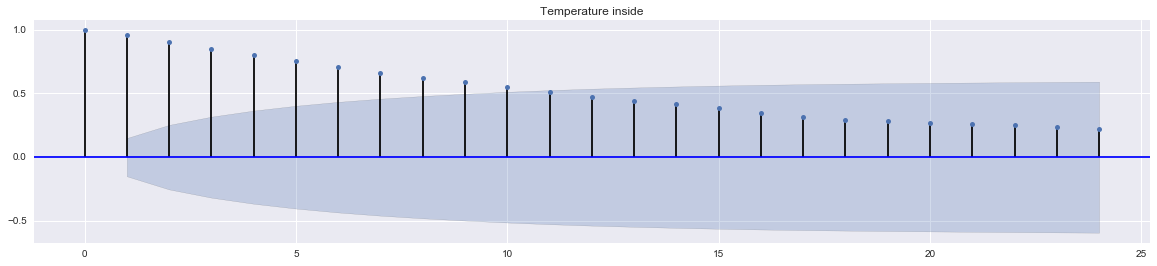

In [65]:
# Autocorrelation of Inside Temperature
acf = plot_acf(ts['temp_in'], lags=24,title="Temperature inside")
acf.set_figheight(4)
acf.set_figwidth(20)
plt.show()

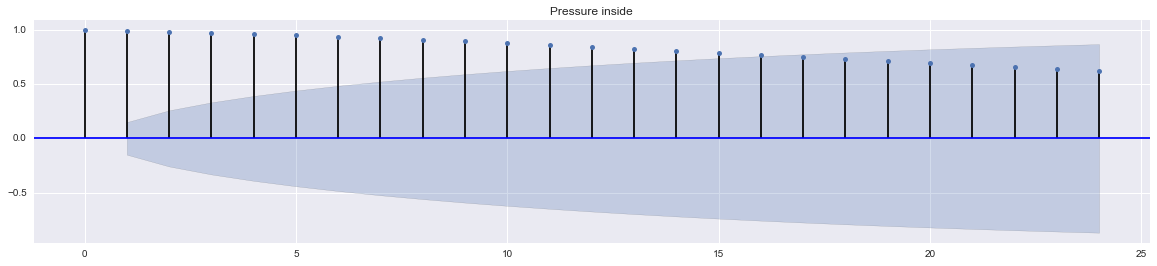

In [66]:
# Autocorrelation of Inside Pressure
acf = plot_acf(ts['press_in'], lags=24,title="Pressure inside")
acf.set_figheight(4)
acf.set_figwidth(20)
plt.show()

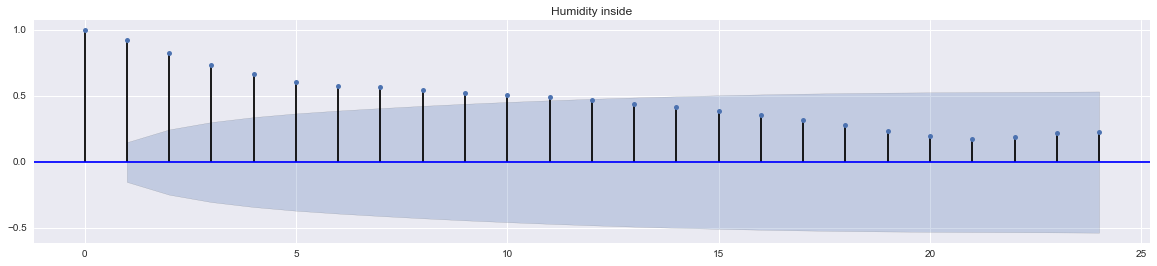

In [67]:
# Autocorrelation of Inside Humidity
acf = plot_acf(ts['hum_in'], lags=24,title="Humidity inside")
acf.set_figheight(4)
acf.set_figwidth(20)
plt.show()

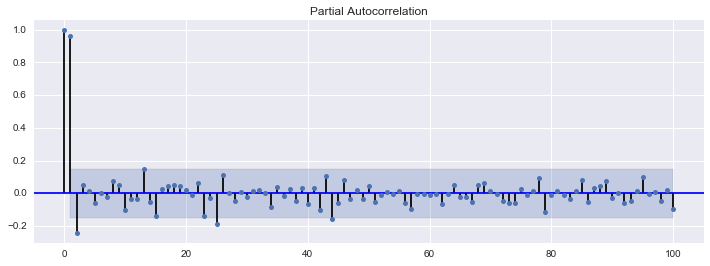

In [72]:
# Partial Autocorrelation of humidity of San Diego
pacf = plot_pacf(ts["temp_in"],lags=100)
pacf.set_figheight(4)
pacf.set_figwidth(12)
plt.show()